# RGNN

## Introduction

## Setup
Here we load required libraries, define paths to data, and define some helper functions. **Feel free to skip this section.**

In [1]:
import numpy as np
import math
import json
import networkx as nx
import itertools

from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from sklearn import manifold

Using backend: pytorch


In [2]:
fp_data = "../datasets/"
fp_data_stargazer = f"{fp_data}github_stargazers/"
fp_data_webmluser = f"{fp_data}git_web_ml/"

In [3]:
# Helper function to visualize stargazer dataset graphs
def plot_stargazer_graph(G, label=None, print_info=False, labels=True):
    # Print info with graph if we want
    if print_info:  
        print(f"{G.number_of_nodes()} vertices")
        print(f"{G.number_of_edges()} edges")
        
    # Grey if no label, pink if 0, green if 1
    col = [[0.7, 0.7, 0.7]]
    if label is not None:
        if label == 0:
            col = [[0.6, 0, 0.6]]
        elif label == 1:
            col = [[0, 0.5, 0]]
    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the reconmmended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=labels, node_color=col)

In [4]:
# Helper function to visualize the webmluser graph
def plot_webmluser_graph(G):    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the reconmmended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, node_color=[[0.7, 0.7, 0.7]])

In [5]:
# Helper for getting batches from a dataset
def get_batches(xs, ys, batch_size=16):
    # How many batches is there of given size for this dataset
    num = len(xs)
    num_batches = math.ceil(num / batch_size)
    
    # Go through and get all batches
    batches_x = []
    batches_y = []
    
    # Get all batches in memory
    for i in range(num_batches - 1):
        sidx = batch_size * i
        fidx = batch_size * (i + 1)
        fidx = min(fidx, num)
        batches_x.append(xs[sidx:fidx])
        batches_y.append(ys[sidx:fidx])
        
    return batches_x, batches_y

## Datasets

### GitHub Stargazers Dataset
12,725 graphs of undirected developer social networks. Again, vertices are users who starred popular machine learning and web development repositories (with at least 10 stars), and edges are mutual follower relationships. The task is to classify each graph as a machine learning, or web development social network.

In [6]:
# Load the ground truth labels. Every element here here is a 
# [graph index, label] pair
stargazer_labels = np.loadtxt(f"{fp_data_stargazer}git_target.csv", \
                                  delimiter=",", skiprows=1)
    
# Adopting the accepted ML notation of input data (x) and labels (y)
stargazer_y = stargazer_labels[:,1].astype(int)

In [7]:
# Then we'll load the edges (defined against vertex ids) - note that there
# are no node or edge features, so predictions are made purely based on 
# undirected graph properties
with open(f"{fp_data_stargazer}git_edges.json") as f:
    stargazer_edges = json.load(f)

In [8]:
# Every item in this dictionary are the edges for a single graph, where each 
# edge is defined as a [vertex index, vertex index] pair. Here we show the 
# first 10 edges from graph 19
stargazer_edges['19'][:10]

[[0, 15],
 [1, 18],
 [1, 3],
 [1, 22],
 [1, 7],
 [1, 9],
 [1, 31],
 [2, 16],
 [3, 16],
 [3, 22]]

In [9]:
# This function takes the data loaded in the stargazer dataset form and turns 
# it into a DGL graph
def make_stargazer_graph(index):
    # Define every edge by its source and destination vertex ids
    edges = np.array(stargazer_edges[f"{index}"])
    src = edges[:,0]
    dst = edges[:,1]
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [10]:
# We can use this data to build each of the 12725 graphs as a single DGL
# graph object, thus forming our graph dataset
stargazer_x = []
for i in range(12725):
    G = make_stargazer_graph(i)
    stargazer_x.append(G)

38 vertices
110 edges


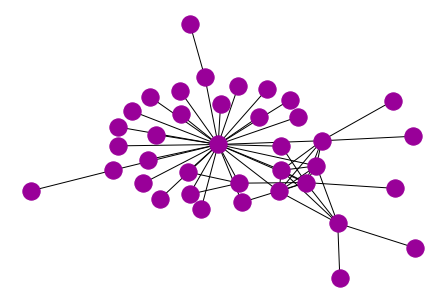

In [11]:
# Lets look at one of our graphs (pink for class 0, green for class 1)
plot_stargazer_graph(stargazer_x[19], label=stargazer_y[24], print_info=True, labels=False)

30 vertices
66 edges


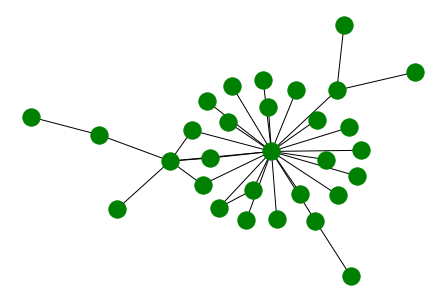

In [12]:
# Lets look at another - noting that the structure alone will be the inputs 
# to the GNN (no vertex or edge features), and that this will be sufficient
# to determine if the social network group is a ML developer group or 
# a Web developer group
plot_stargazer_graph(stargazer_x[24], label=stargazer_y[2], print_info=True, labels=False)

### GitHub Web or Machine Learning Dataset
One single graph representing the GitHub social network: vertices are users (who have starred at least 10 repositories) and edges represent if they mutually follow eachother. Each node has input features derived from profile data (location, repositories starred, employer and e-mail address), and belongs to one of two classes (derived from the user's job title): a web developer or machine learning developer. 

Note that using a single graph represents a departure from traditional supervised machine learning, where we typically use hundreds or thousands of training instances. In this application, it is perhaps easier to consider the **vertices** of the graph as training instances. Indeed, we will reserve some vertices for training and some for testing.

In [13]:
# Lets start by loading the vertices with their ground truth labels 
# and names attached. Every element is a [vertex index, name, label] triplet
webmluser_labels = np.loadtxt(f"{fp_data_webmluser}musae_git_target.csv", \
                                  delimiter=",", skiprows=1, usecols=[0,2])
webmluser_y = webmluser_labels[:,1].astype(int)

In [14]:
# Now load the associated vertex features
with open(f"{fp_data_webmluser}musae_git_features.json") as f:
    webmluser_features = json.load(f)

In [15]:
# There are 37700 vertices here, with each index keying into the features
# dictionary we just loaded. Here is an example of one vertex's features
print(webmluser_features['9001'])

[2657, 509, 3214, 3541, 3129, 1852, 3077, 3763, 536, 137, 2788, 1532, 3771, 234, 1991, 3813, 1651, 3887]


In [16]:
# Then we'll load the edges (defined against vertex id pairs)
webmluser_edges = np.loadtxt(f"{fp_data_webmluser}musae_git_edges.csv", \
                                  delimiter=",", skiprows=1)

In [17]:
# We only need to make on graph here, and that is our 'dataset'
def make_webmluser_graph():
    # Define every edge by its source and destination vertex ids
    src = webmluser_edges[:,0]
    dst = webmluser_edges[:,1]
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    G = dgl.DGLGraph((u, v))
    
    # TODO vertex features
    
    return G

In [18]:
# Build the graph from the data - note that this is a big graph
webmluser_x = make_webmluser_graph()
print(f"{webmluser_x.number_of_nodes()} nodes")
print(f"{webmluser_x.number_of_edges()} edges")

37700 nodes
578006 edges


## Architectures
True RGNNs are seldom used in contemporary GNN work. RGNNs require a transition function to be repeatedly applied until convergence of the hidden states - an expensive computation. Instead of use true RGNNs here, we'll use GCNs with varying numbers of layers, thus mimicking the repeated application of a transition function.

In [19]:
# We want to experiment with the amount of computation required in the 
# forward pass, so we'll build various GNNs here, each with different 
# numbers of transition function layers
class StargazerGNN(nn.Module):
    def __init__(self, num_hidden_features):
        super().__init__()
        
        # We'll apply some number of spatial convolutions / message passing 
        # RGNNs
        self.convs = nn.ModuleList()
        for i in range(len(num_hidden_features) - 1):
            self.convs.append(GraphConv(num_hidden_features[i], 
                                        num_hidden_features[i+1]))
            
        # Classify out to one of two classes
        self.classify = nn.Linear(num_hidden_features[-1], 2)

    def forward(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
            
        # Calculate graph representation by averaging all the node 
        # representations, thus making a graph representation
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        output = self.classify(hg)
        return output

    def hidden(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
        
        return h

## Experiments

### Training and Testing

In [20]:
# The following operations will train the GNN
def train_stargazer_gnn(gnn, num_epochs):
    loss_func = nn.MSELoss()
    opt = torch.optim.Adam(itertools.chain(gnn.parameters()), 
                           lr=0.001)

    # Get the batches to work with
    num_train = 8096
    batches_x, batches_y = get_batches(stargazer_x[:num_train], \
                                       stargazer_y[:num_train], \
                                       batch_size=64)

    # Run every batch in every epoch
    epoch_losses = []
    for epoch_index in range(num_epochs):
        epoch_loss = 0
        for batch_index in range(len(batches_x)):
            # Get the batch of interest
            batch_x = batches_x[batch_index]
            batch_y = batches_y[batch_index]

            # Calculate an output for each graph
            x = dgl.batch(batch_x)
            y_hat = gnn(x)

            # And compare to the true value
            y = F.one_hot(torch.tensor(batch_y), num_classes=2).float()

            #print(y_hat)
            #print(y)

            # Calculate loss 
            loss = loss_func(y_hat, y)

            # Calculate loss and perform gradient descent step accordingly
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        epoch_loss /= len(batches_x)
        print(f"Epoch {epoch_index}: loss {epoch_loss}")
        epoch_losses.append(epoch_loss)
        
    # Return the trained architecture and loss
    return epoch_losses
    

In [21]:
# The following operation will test the GNN, returning hidden representations and 
# predictions
def test_stargazer_gnn(gnn):
    num_train = 8096
    num_test = 2048

    batches_x, batches_y = get_batches(stargazer_x[num_train:num_train+num_test],\
                                       stargazer_y[num_train:num_train+num_test],\
                                       batch_size=1)

    num_correct = 0
    y_true = []
    y_pred = []
    hidden = []
    for batch_index in range(len(batches_x)):
        # Get the batch of interest
        batch_x = batches_x[batch_index]
        batch_y = batches_y[batch_index]

        # Calculate an output for each graph
        x = dgl.batch(batch_x)
        y_hat = gnn(x)
        y_hat = torch.argmax(y_hat, dim=1).detach().numpy()

        # Also get some hidden representations for plotting
        h = torch.mean(gnn.hidden(x), dim=0).detach().numpy()
        hidden.append(h)

        # Take note of everything
        y_pred.extend(y_hat)
        y_true.extend(batch_y)
    hidden = np.array(hidden)
    
    return hidden, y_true, y_pred

As en example, lets now use these functions to train and test a Stargazer GNN.

In [22]:
stargazer_gnn_example = StargazerGNN([1, 4, 4, 4])
epoch_losses = train_stargazer_gnn(stargazer_gnn_example, 8)

Epoch 0: loss 0.43773745615330956
Epoch 1: loss 0.289755663583203
Epoch 2: loss 0.26315135650691535
Epoch 3: loss 0.25390835910562487
Epoch 4: loss 0.24963119034729306
Epoch 5: loss 0.24820309061379658
Epoch 6: loss 0.2478494212504417
Epoch 7: loss 0.247737899067856


In [23]:
hidden, y_true, y_pred = test_stargazer_gnn(stargazer_gnn_example)

In [24]:
print(metrics.classification_report(y_true, y_pred, \
                                    target_names=['web', 'ml']))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print(f"AUC\t{metrics.auc(fpr, tpr)}")

              precision    recall  f1-score   support

         web       0.55      0.10      0.18       991
          ml       0.52      0.92      0.67      1056

    accuracy                           0.52      2047
   macro avg       0.53      0.51      0.42      2047
weighted avg       0.53      0.52      0.43      2047

AUC	0.5117525532825734


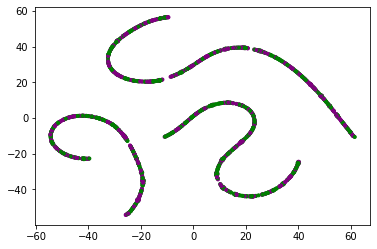

In [25]:
# Plot a TSNE fit on the features
tsne = manifold.TSNE(n_components=2)
tsne_embedded = tsne.fit_transform(hidden)
tsne_embedded.shape
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
            marker='.', c=y_true, 
            cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

### Results and Discussion

In [26]:
# Now lets wrap all this up into one function so we can test 
# multiple architectures
def train_test_architecture(num_hidden_features, num_epochs):
    # Make architecture and train
    gnn_run = StargazerGNN(num_hidden_features)
    epoch_losses = train_stargazer_gnn(gnn_run, num_epochs)
    
    if num_epochs > 0:
        plt.plot(range(num_epochs), epoch_losses)
        plt.ylim((0, 1.0))
        plt.title("Loss during training")
        plt.show()
    
    # Test and return hidden representations plus predictions
    hidden, y_true, y_pred = test_stargazer_gnn(gnn_run)
    
    # Print performance metrics
    print(metrics.classification_report(y_true, y_pred, \
                                        target_names=['web', 'ml']))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    print(f"AUC\t{metrics.auc(fpr, tpr)}")
    
    # Plot TSNE visualization
    tsne = manifold.TSNE(n_components=2)
    tsne_embedded = tsne.fit_transform(hidden)
    tsne_embedded.shape
    plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
                marker='.', c=y_true, 
                cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

              precision    recall  f1-score   support

         web       0.48      0.82      0.60       991
          ml       0.48      0.16      0.24      1056

    accuracy                           0.48      2047
   macro avg       0.48      0.49      0.42      2047
weighted avg       0.48      0.48      0.41      2047

AUC	0.48935686328471395


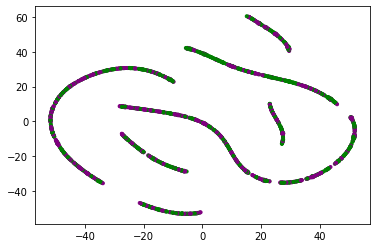

In [27]:
train_test_architecture([1, 8], 0)

Epoch 0: loss 1.0382930007245805
Epoch 1: loss 0.40677758696533384
Epoch 2: loss 0.3151225246607311
Epoch 3: loss 0.29807620909478927
Epoch 4: loss 0.2877928039857319
Epoch 5: loss 0.27887964698057327
Epoch 6: loss 0.27132706675264573
Epoch 7: loss 0.26511238515377045
Epoch 8: loss 0.2601731644263343
Epoch 9: loss 0.2563915482116124
Epoch 10: loss 0.25356267936645993
Epoch 11: loss 0.25150086103923736
Epoch 12: loss 0.25003109836862203
Epoch 13: loss 0.24899987332404605
Epoch 14: loss 0.2482835232974991
Epoch 15: loss 0.24778910761787779


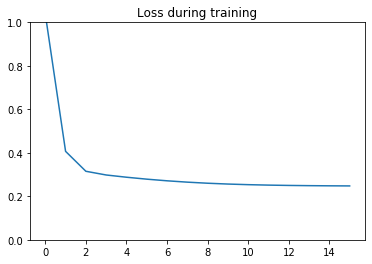

              precision    recall  f1-score   support

         web       0.57      0.11      0.19       991
          ml       0.53      0.92      0.67      1056

    accuracy                           0.53      2047
   macro avg       0.55      0.52      0.43      2047
weighted avg       0.55      0.53      0.44      2047

AUC	0.5172403907898357


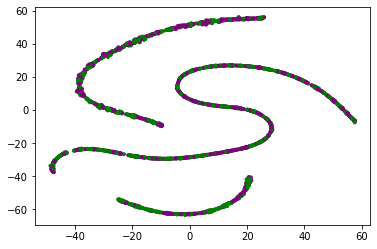

In [28]:
train_test_architecture([1, 8], 16)

Epoch 0: loss 0.43083869606729536
Epoch 1: loss 0.31648813944960397
Epoch 2: loss 0.2913411943212388
Epoch 3: loss 0.2709427849640922
Epoch 4: loss 0.25805768749070546
Epoch 5: loss 0.25254185947160873
Epoch 6: loss 0.2509385950508572
Epoch 7: loss 0.2504446746574508
Epoch 8: loss 0.25014102967485546
Epoch 9: loss 0.2498658382230335
Epoch 10: loss 0.24960340263824615
Epoch 11: loss 0.24935409154683824
Epoch 12: loss 0.2491259648213311
Epoch 13: loss 0.2489292441852509
Epoch 14: loss 0.24875190061709238
Epoch 15: loss 0.2485874971700093


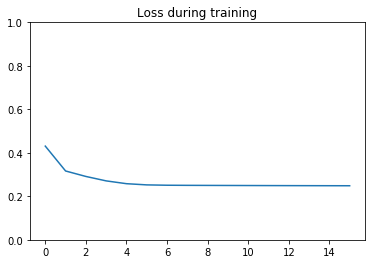

/home/prang/miniconda3/envs/gnn-tutorial/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         web       0.00      0.00      0.00       991
          ml       0.52      1.00      0.68      1056

    accuracy                           0.52      2047
   macro avg       0.26      0.50      0.34      2047
weighted avg       0.27      0.52      0.35      2047

AUC	0.5


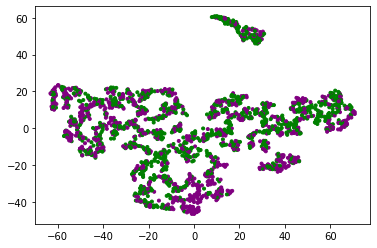

In [29]:
train_test_architecture([1, 8, 8], 16)

Epoch 0: loss 0.31326293992617776
Epoch 1: loss 0.255505711313278
Epoch 2: loss 0.25081656956010395
Epoch 3: loss 0.24937441803160168
Epoch 4: loss 0.24895859592490727
Epoch 5: loss 0.2486366933536908
Epoch 6: loss 0.24827173340415198
Epoch 7: loss 0.24785439693738545
Epoch 8: loss 0.2473921412749896
Epoch 9: loss 0.24688473556722915
Epoch 10: loss 0.24633822460023183
Epoch 11: loss 0.24575576410880165
Epoch 12: loss 0.24512277803723775
Epoch 13: loss 0.2443736648512265
Epoch 14: loss 0.24350878785526942
Epoch 15: loss 0.2426814292631452


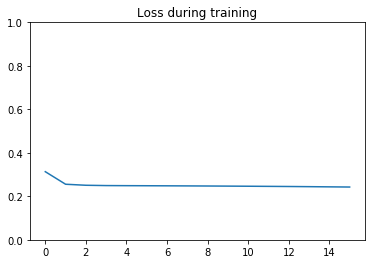

              precision    recall  f1-score   support

         web       0.69      0.26      0.38       991
          ml       0.56      0.89      0.69      1056

    accuracy                           0.59      2047
   macro avg       0.63      0.58      0.53      2047
weighted avg       0.62      0.59      0.54      2047

AUC	0.5757207863192979


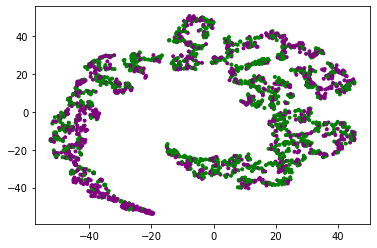

In [30]:
train_test_architecture([1, 8, 8, 8, 8], 16)

Epoch 0: loss 0.26665325675691876
Epoch 1: loss 0.24735317710373136
Epoch 2: loss 0.2448981050697584
Epoch 3: loss 0.24135372255529677
Epoch 4: loss 0.23706273923790644
Epoch 5: loss 0.23252610034412807
Epoch 6: loss 0.22881797559204556
Epoch 7: loss 0.22631224505012
Epoch 8: loss 0.22465196500221887
Epoch 9: loss 0.22349269120466142
Epoch 10: loss 0.22265185758708014
Epoch 11: loss 0.22207064004171462
Epoch 12: loss 0.22126696388872844
Epoch 13: loss 0.22067490089980382
Epoch 14: loss 0.2201284124028115
Epoch 15: loss 0.2196727470746116


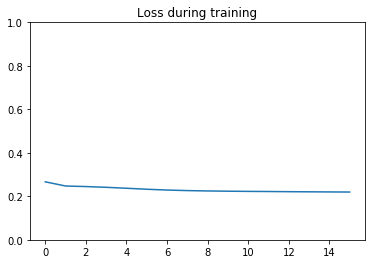

              precision    recall  f1-score   support

         web       0.71      0.46      0.56       991
          ml       0.62      0.82      0.70      1056

    accuracy                           0.65      2047
   macro avg       0.66      0.64      0.63      2047
weighted avg       0.66      0.65      0.63      2047

AUC	0.6406751674158334


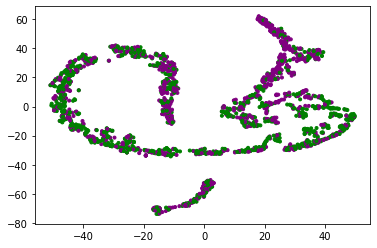

In [31]:
train_test_architecture([1, 8, 8, 8, 8, 8, 8, 8, 8, 8], 16)